In [1]:
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split

import torch.nn as nn
import time
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML
from tabulate import tabulate
from IPython.display import clear_output

import sys
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Models")
from Networks_v2 import Net_Individual

sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Experimental_setup")
from Experiment_v5 import Experiment
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Training")
from Training_Networks_frozen_weights import Training_frozen_weights
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Analysis")
from Check import Checkup

sys.path.append("/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis")
from Manifold_Analysis import Manifold_analysis

from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances

from matplotlib.ticker import NullFormatter
from collections import OrderedDict
from functools import partial
from sklearn import manifold, datasets

In [2]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)

    print(f'Random seed {seed} has been set.')

SEED = 2021
set_seed(seed=SEED)
# if gpu is to be used
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print("Device: ", device)

G_SEED = torch.Generator()
G_SEED.manual_seed(SEED)

Device:  cpu
Random seed 2021 has been set.


## Generate the Dataset

In [11]:
WIDTH = 100
BATCH_SIZE = 32
Nodes_Second = 10
Nodes_Third = 10
EPOCH = 50
ITERATION = 1

In [4]:
set_seed(seed=SEED)
experiment = Experiment(width = WIDTH,batch_size=BATCH_SIZE,size_output_multi=2)
dataset_train,dataset_space_train,dataset_weather_train,dataset_val,dataset_space_val,dataset_weather_val,dataset_test,dataset_space_test,dataset_weather_test= experiment.Generate_data()

Random seed 2021 has been set.
Test size dataset space torch.Size([999, 6])
Test size dataset weather torch.Size([999, 6])
Train size dataset space torch.Size([7000, 6])
Train size dataset weather torch.Size([7000, 6])


In [5]:
train_loader_weather = torch.utils.data.DataLoader(dataset_weather_train,batch_size=10,shuffle = False )
val_loader_weather = torch.utils.data.DataLoader(dataset_weather_val,batch_size=1,shuffle = False )
test_loader_weather = torch.utils.data.DataLoader(dataset_weather_test,batch_size=1,shuffle = False ) #bATCH SIZE =1 HERE FOR THE DATASET ONLY, ELSE TAKE WHATEVER BATCH SIZE IN INDIVIDUAL MODE

In [6]:
train_loader_space = torch.utils.data.DataLoader(dataset_space_train,batch_size=10,shuffle = False )
val_loader_space = torch.utils.data.DataLoader(dataset_space_val,batch_size=10,shuffle = False )
test_loader_space = torch.utils.data.DataLoader(dataset_space_test,batch_size=1,shuffle = False ) #bATCH SIZE =1 HERE FOR THE DATASET ONLY, ELSE TAKE WHATEVER BATCH SIZE IN INDIVIDUAL MODE

## Analysis setup

In [7]:
do_analysis = False
type_an = frequence = np.NaN
network_type = frequence = np.NaN
frequence = np.NaN

# Individual Networks

In [8]:
option_interleaved = False

In [12]:
weather_losses = []

for i in range(ITERATION):
    print("Iteration",i)
    
    Input_Dimension = 3
    model_weather = Net_Individual(Input_Dimension ,Nodes_Second,Nodes_Third,1)  
    optimizer_weather = torch.optim.Adam(model_weather.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    criterion = nn.BCEWithLogitsLoss()
    spatial_task = False

    training = Training_frozen_weights()
    model_weather,val_losses = training.training_individual(model_weather,optimizer_weather,criterion,EPOCH,train_loader_weather,val_loader_weather,test_loader_weather,spatial_task,do_analysis,type_an,network_type,frequence)
    weather_losses.append(val_losses)

Iteration 0


In [13]:
spatial_losses = []

for i in range(ITERATION):
    print("Iteration",i)
    Input_Dimension = 2
    model_space = Net_Individual(Input_Dimension ,Nodes_Second,Nodes_Third,1)    
    optimizer_space = torch.optim.Adam(model_space.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    spatial_task = True
    
    training = Training_frozen_weights()
    model_space,val_losses = training.training_individual(model_space,optimizer_space,criterion,EPOCH,train_loader_space,val_loader_space,test_loader_space,spatial_task,do_analysis,type_an,network_type,frequence)
    spatial_losses.append(val_losses)

Iteration 0


In [14]:
spatial_losses_option_0 = torch.tensor(spatial_losses)
weather_losses_option_0 = torch.tensor(weather_losses)

In [15]:
print(spatial_losses_option_0.shape)

torch.Size([1, 50])


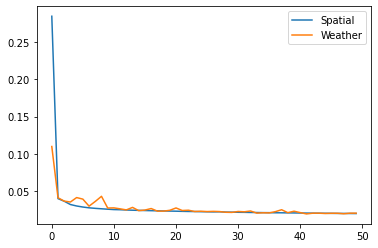

In [20]:
epoch = [i for i in range(spatial_losses_option_0.shape[1])]
plt.figure()
plt.plot(epoch,spatial_losses_option_0.squeeze(0),label = "Spatial")
plt.plot(epoch,weather_losses_option_0.squeeze(0),label = "Weather")

plt.legend()

# Frozen weights

In [21]:
ITERATION = 10
EPOCH = 50

# Interleaved Training

In [22]:
option_interleaved = True

## Train the Models

In [25]:
weather_losses_g = []
spatial_losses_g = []

for i in range(ITERATION):
    print("Iteration",i)
    weather_losses = []
    spatial_losses = []
    
    Input_Dimension = 3
    model_weather = Net_Individual(input_dimension=3,nodes_second = Nodes_Second,nodes_third = Nodes_Third,nodes_output = 1)  
    optimizer_weather = torch.optim.Adam(model_weather.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    Input_Dimension = 2
    model_space = Net_Individual(Input_Dimension ,Nodes_Second,Nodes_Third,1)    
    optimizer_space = torch.optim.Adam(model_space.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    criterion = nn.BCEWithLogitsLoss()
    for epoch in range(EPOCH):
      
        training = Training_frozen_weights()
        spatial_task = False
        model_weather,val_losses = training.training_individual(model_weather,optimizer_weather,criterion,1,train_loader_weather,val_loader_weather,test_loader_weather,spatial_task,do_analysis,type_an,network_type,frequence)
        weather_losses.append(val_losses)

        spatial_task = True
        model_space.fc2[0].weight = model_weather.fc2[0].weight
        model_space.fc3[0].weight = model_weather.fc3[0].weight

        for param in model_space.fc2.parameters():
            param.requires_grad = False

        for param in model_space.fc3.parameters():
            param.requires_grad = False

        model_space,val_losses = training.training_individual(model_space,optimizer_space,criterion,1,train_loader_space,val_loader_space,test_loader_space,spatial_task,do_analysis,type_an,network_type,frequence)
        spatial_losses.append(val_losses)
        
    weather_losses_tensor = torch.tensor(weather_losses).flatten()
    spatial_losses_tensor = torch.tensor(spatial_losses).flatten()
    
    weather_losses_g.append(weather_losses_tensor.tolist())
    spatial_losses_g.append(spatial_losses_tensor.tolist())
       


Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


In [26]:
spatial_losses_option_2 = torch.tensor(spatial_losses_g)
weather_losses_option_2 = torch.tensor(weather_losses_g)

# Vanilla training

In [27]:
option_interleaved = False

### Train Network

In [28]:
weather_losses = []
spatial_losses = []



for i in range(ITERATION):
    print("Iteration",i)
    Input_Dimension = 3
    model_weather = Net_Individual(Input_Dimension ,Nodes_Second,Nodes_Third,1)  
    optimizer_weather = torch.optim.Adam(model_weather.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    criterion = nn.BCEWithLogitsLoss()
    spatial_task = False
    
    training = Training_frozen_weights()
    model_weather,val_losses = training.training_individual(model_weather,optimizer_weather,criterion,EPOCH,train_loader_weather,val_loader_weather,test_loader_weather,spatial_task,do_analysis,type_an,network_type,frequence)
    weather_losses.append(val_losses)
    
    
    Input_Dimension = 2
    model_space = Net_Individual(Input_Dimension ,Nodes_Second,Nodes_Third,1)    
    optimizer_space = torch.optim.Adam(model_space.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    spatial_task = True
    
    model_space.fc2[0].weight = model_weather.fc2[0].weight
    model_space.fc3[0].weight = model_weather.fc3[0].weight

    for param in model_space.fc2.parameters():
        param.requires_grad = False

    for param in model_space.fc3.parameters():
         param.requires_grad = False
    
    training = Training_frozen_weights()
    model_space,val_losses = training.training_individual(model_space,optimizer_space,criterion,EPOCH,train_loader_space,val_loader_space,test_loader_space,spatial_task,do_analysis,type_an,network_type,frequence)
    spatial_losses.append(val_losses)
    
    
    
    

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


In [29]:
spatial_losses_option_1 = torch.tensor(spatial_losses)
weather_losses_option_1 = torch.tensor(weather_losses)

## Display Dynamic

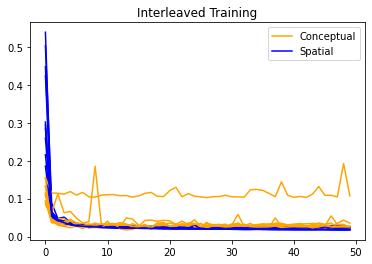

In [30]:
epochs = [i for i in range(len(weather_losses_option_1[0]))]
plt.figure()
plt.title("Interleaved Training")
for i in range(ITERATION):
    if i == 0:
        plt.plot(epochs,weather_losses_option_1[i],"orange",label= "Conceptual")
        plt.plot(epochs,spatial_losses_option_1[i] ,"blue",label= "Spatial")
    else:
        plt.plot(epochs,weather_losses_option_1[i],"orange")
        plt.plot(epochs,spatial_losses_option_1[i] ,"blue")
        
plt.legend()

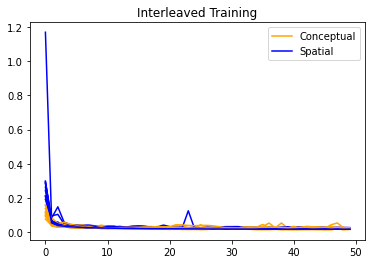

In [31]:
epochs = [i for i in range(len(weather_losses_option_2[0]))]
plt.figure()
plt.title("Interleaved Training")
for i in range(ITERATION):
    if i == 0:
        plt.plot(epochs,weather_losses_option_2[i],"orange",label= "Conceptual")
        plt.plot(epochs,spatial_losses_option_2[i] ,"blue",label= "Spatial")
    else:
        plt.plot(epochs,weather_losses_option_2[i],"orange")
        plt.plot(epochs,spatial_losses_option_2[i] ,"blue")
        
plt.legend()

## Average comparison

In [32]:
weather_mean_option_2 = torch.mean(weather_losses_option_2,0)
spatial_mean_option_2 = torch.mean(spatial_losses_option_2,0)

weather_mean_option_1 = torch.mean(weather_losses_option_1,0)
spatial_mean_option_1 = torch.mean(spatial_losses_option_1,0)

weather_mean_option_0 = torch.mean(weather_losses_option_0,0)
spatial_mean_option_0 = torch.mean(spatial_losses_option_0,0)


In [33]:
weather_var_option_2 = torch.var(weather_losses_option_2,0)
spatial_var_option_2 = torch.var(spatial_losses_option_2,0)


weather_var_option_1 = torch.var(weather_losses_option_1,0)
spatial_var_option_1 = torch.var(spatial_losses_option_1,0)

weather_var_option_0 = torch.var(weather_losses_option_0,0)
spatial_var_option_0 = torch.var(spatial_losses_option_0,0)

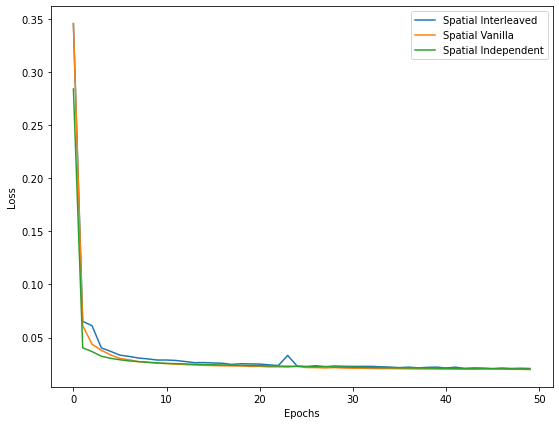

In [39]:
plt.figure(figsize = (9,7))
#plt.plot(epochs,weather_mean_option_2,"--",label= "Conceptual Interleaved")
plt.plot(epochs,spatial_mean_option_2,label= "Spatial Interleaved")
#plt.fill_between(epochs, weather_mean_option_2 - weather_var_option_2, weather_mean_option_2 + weather_var_option_2,color='gray', alpha=0.5)
#plt.fill_between(epochs, spatial_mean_option_2 - spatial_var_option_2, spatial_mean_option_2 + spatial_var_option_2,color='gray', alpha=0.5)


#plt.plot(epochs,weather_mean_option_1,"--",label= "Conceptual Vanilla")
plt.plot(epochs,spatial_mean_option_1,label= "Spatial Vanilla")
#plt.fill_between(epochs, weather_mean_option_1 - weather_var_option_1, weather_mean_option_1 + weather_var_option_1,color='gray', alpha=0.5)
#plt.fill_between(epochs, spatial_mean_option_1 - spatial_var_option_1, spatial_mean_option_1 + spatial_var_option_1,color='gray', alpha=0.5)

#plt.plot(epochs,weather_mean_option_0,"--",label= "Conceptual Independent")
plt.plot(epochs,spatial_mean_option_0,label= "Spatial Independent")
#plt.fill_between(epochs, weather_mean_option_0 - weather_var_option_0, weather_mean_option_0 + weather_var_option_0,color='gray', alpha=0.5)
#plt.fill_between(epochs, spatial_mean_option_0 - spatial_var_option_0, spatial_mean_option_0 + spatial_var_option_0,color='gray', alpha=0.5)

plt.ylabel("Loss")

plt.xlabel("Epochs")



plt.legend()